### 📦 Module 1: Data Acquisition and Preprocessing

**Objective:**  
Pull historical asset price data and relevant Treasury yields, then compute basic return metrics.

**Instructions:**
1. Use `yfinance.download()` to fetch adjusted close prices for a ticker (e.g., `AAPL`).
2. Compute log returns:  $$r_t = \log\left(\frac{S_t}{S_{t-1}}\right)$$
3. Download macroeconomic indicators (e.g., 3M, 5Y, 10Y, 30Y Treasury yields).
4. Ensure consistent indexing (dates aligned, missing values handled).
5. Store all clean features in a single DataFrame for downstream modeling.
6. Plot return series and volatilities to visually inspect.



In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# --- Step 1: Download stock price data ---
ticker = "AAPL"  # Change to other tickers like "MSFT", "GOOG", etc.
start_date = "2015-01-01"
end_date = "2024-01-01"

# Download historical price data
data = yf.download(ticker, start=start_date, end=end_date)

/tmp/ipython-input-1-456586794.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2264 entries, 2015-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   2264 non-null   float64
 1   (High, AAPL)    2264 non-null   float64
 2   (Low, AAPL)     2264 non-null   float64
 3   (Open, AAPL)    2264 non-null   float64
 4   (Volume, AAPL)  2264 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 106.1 KB


/tmp/ipython-input-3-2797497808.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3-2797497808.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  treasury = yf.download(symbol, start=start_date, end=end_date)['Close']
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3-2797497808.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  treasury = yf.download(symbol, start=start_date, end=end_date)['Close']
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3-2797497808.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  treasury = yf.download(symbol, start=start_date, end=end_date)['Close']
[*********************100%****************

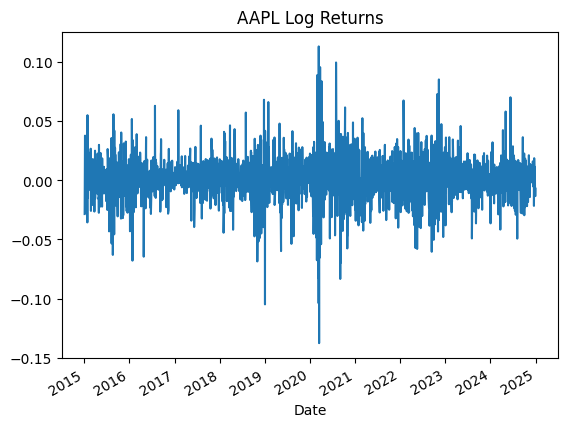

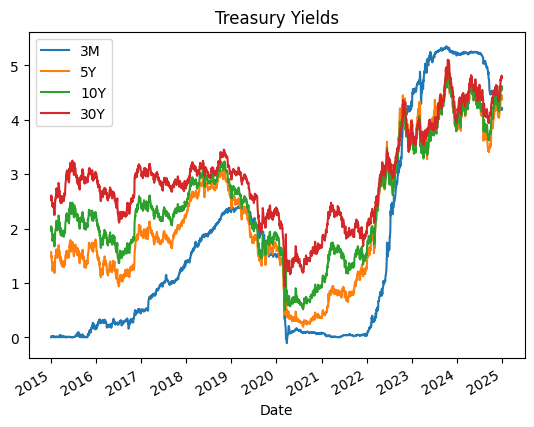

In [3]:
# Module 1: Data Acquisition and Preprocessing

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# --- Step 1: Download stock price data ---
ticker = "AAPL"
start_date = "2015-01-01"
end_date = "2025-01-01"

data = yf.download(ticker, start=start_date, end=end_date)
close_price = data[('Close', 'AAPL')]  # MultiIndex columns

# --- Step 2: Compute log returns ---
returns = np.log(close_price / close_price.shift(1)).dropna()

# --- Step 3: Load Treasury data ---
treasury_symbols = {
    "3M": "^IRX",        # 3-Month Treasury Bill Rate
    "5Y": "^FVX",        # 5-Year Treasury Yield
    "10Y": "^TNX",       # 10-Year Treasury Yield
    "30Y": "^TYX"        # 30-Year Treasury Yield
}

treasury_data = pd.DataFrame()
for label, symbol in treasury_symbols.items():
    treasury = yf.download(symbol, start=start_date, end=end_date)['Close']
    treasury_data[label] = treasury

# --- Step 4: Merge features ---
features = pd.concat([returns.rename("Log_Returns"), treasury_data], axis=1).dropna()

# --- Step 5: Visual inspection ---
features["Log_Returns"].plot(title=f"{ticker} Log Returns")
plt.show()

features[["3M", "5Y", "10Y", "30Y"]].plot(title="Treasury Yields")
plt.show()


### ⚙️ Module 2: Heston Model Core – Analytics & Simulation

**Objective:**  
Build two engines for option pricing under Heston:  
- Analytical engine using characteristic function  
- Simulation engine using Euler-Maruyama

**Instructions:**
1. Implement the Heston characteristic function using complex arithmetic.
2. Numerically integrate the characteristic function to compute call prices using the Fourier approach.
3. Implement the Euler-Maruyama scheme to simulate asset and volatility paths.
   - Use **full truncation** to ensure variance is non-negative.
4. Write two functions: `price_analytical(...)`, `simulate_paths(...)`.


Use `quad` for integration.To simulate variance, apply:
$$
v_{t+\Delta t} = \max\left(v_t + \kappa(\theta - v_t)\Delta t + \sigma\sqrt{v_t} \Delta W_t, 0\right)$$


In [4]:
import numpy as np
from scipy.integrate import quad
from scipy.stats import norm

# --- Heston Characteristic Function ---
def heston_char_func(phi, S, K, T, r, kappa, theta, sigma, rho, v0, Pnum):
    u = 0.5 if Pnum == 1 else -0.5
    b = kappa - rho * sigma if Pnum == 1 else kappa
    a = kappa * theta

    d = np.sqrt((rho * sigma * 1j * phi - b)**2 - sigma**2 * (2 * u * 1j * phi - phi**2))
    g = (b - rho * sigma * 1j * phi + d) / (b - rho * sigma * 1j * phi - d)

    C = (r * 1j * phi * T) + (a / sigma**2) * (
        (b - rho * sigma * 1j * phi + d) * T -
        2 * np.log((1 - g * np.exp(d * T)) / (1 - g))
    )
    D = ((b - rho * sigma * 1j * phi + d) / sigma**2) * (
        (1 - np.exp(d * T)) / (1 - g * np.exp(d * T))
    )

    return np.exp(C + D * v0 + 1j * phi * np.log(S))

# --- Analytical Price using Fourier Integration ---
def heston_price_analytical(S, K, T, r, params):
    kappa, theta, sigma, rho, v0 = params

    def integrand(phi, Pnum):
        numerator = np.exp(-1j * phi * np.log(K)) * heston_char_func(
            phi, S, K, T, r, kappa, theta, sigma, rho, v0, Pnum
        )
        return np.real(numerator / (1j * phi))

    integral1 = quad(lambda phi: integrand(phi, 1), 0, 100, limit=100)[0]
    integral2 = quad(lambda phi: integrand(phi, 2), 0, 100, limit=100)[0]

    P1 = 0.5 + (1 / np.pi) * integral1
    P2 = 0.5 + (1 / np.pi) * integral2

    call_price = S * P1 - K * np.exp(-r * T) * P2
    return call_price

# --- Monte Carlo Simulation using Euler–Maruyama ---
def heston_mc_simulation(S0, v0, T, r, params, N=10000, M=252):
    kappa, theta, sigma, rho, _ = params  # Note: v0 already passed separately
    dt = T / M
    S = np.zeros((N, M + 1))
    v = np.zeros((N, M + 1))
    S[:, 0] = S0
    v[:, 0] = v0  # Initial variance

    for t in range(1, M + 1):
        Z1 = np.random.randn(N)
        Z2 = np.random.randn(N)
        W1 = Z1
        W2 = rho * Z1 + np.sqrt(1 - rho ** 2) * Z2  # Correlated Brownian motions

        v_prev = np.maximum(v[:, t - 1], 0)
        v[:, t] = np.maximum(
            v[:, t - 1] + kappa * (theta - v_prev) * dt + sigma * np.sqrt(v_prev) * np.sqrt(dt) * W2,
            0
        )

        S[:, t] = S[:, t - 1] * np.exp(
            (r - 0.5 * v_prev) * dt + np.sqrt(v_prev) * np.sqrt(dt) * W1
        )

    return S, v

# --- Monte Carlo Option Pricing ---
def price_mc(S, K, T, r):
    # European Call Option Price via MC
    payoff = np.maximum(S[:, -1] - K, 0)
    return np.exp(-r * T) * np.mean(payoff)


### 🧮 Module 3: Unified Option Pricing Interface

**Objective:**  
Wrap all pricing engines (BSM, Heston Analytical, Heston MC) into a single interface.

**Instructions:**
1. Inherit from the Heston class and build `OptionPricer`.
2. Add BSM pricing as a fallback model.
3. Implement a method `price_option(engine='bs'|'heston'|'mc')` that dispatches to the selected method.
4. Add handling for call/put options, and print comparison tables.




In [5]:
import numpy as np
from scipy.stats import norm
from scipy.integrate import quad

class OptionPricer:
    def __init__(self, S, K, T, r, sigma, heston_params):
        self.S = S      # Spot Price
        self.K = K      # Strike Price
        self.T = T      # Time to Maturity
        self.r = r      # Risk-Free Rate
        self.sigma = sigma  # Volatility (for BS)
        self.heston_params = heston_params  # (kappa, theta, sigma, rho, v0)

    # --- Black-Scholes Pricing ---
    def price_bs(self, call=True):
        d1 = (np.log(self.S / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
        d2 = d1 - self.sigma * np.sqrt(self.T)
        if call:
            bs_price = self.S * norm.cdf(d1) - self.K * np.exp(-self.r * self.T) * norm.cdf(d2)
        else:
            bs_price = self.K * np.exp(-self.r * self.T) * norm.cdf(-d2) - self.S * norm.cdf(-d1)
        return bs_price

    # --- Heston Analytical Price (Fourier Integration) ---
    def price_heston_analytical(self, call=True):
        kappa, theta, sigma, rho, v0 = self.heston_params

        def heston_char_func(phi, Pnum):
            u = 0.5 if Pnum == 1 else -0.5
            b = kappa - rho * sigma if Pnum == 1 else kappa
            a = kappa * theta
            d = np.sqrt((rho * sigma * 1j * phi - b) ** 2 - sigma ** 2 * (2 * u * 1j * phi - phi ** 2))
            g = (b - rho * sigma * 1j * phi + d) / (b - rho * sigma * 1j * phi - d)
            C = (self.r * 1j * phi * self.T) + (a / sigma ** 2) * (
                (b - rho * sigma * 1j * phi + d) * self.T -
                2 * np.log((1 - g * np.exp(d * self.T)) / (1 - g))
            )
            D = ((b - rho * sigma * 1j * phi + d) / sigma ** 2) * (
                (1 - np.exp(d * self.T)) / (1 - g * np.exp(d * self.T))
            )
            return np.exp(C + D * v0 + 1j * phi * np.log(self.S))

        def integrand(phi, Pnum):
            numerator = np.exp(-1j * phi * np.log(self.K)) * heston_char_func(phi, Pnum)
            return np.real(numerator / (1j * phi))

        integral1 = quad(lambda phi: integrand(phi, 1), 0, 100, limit=100)[0]
        integral2 = quad(lambda phi: integrand(phi, 2), 0, 100, limit=100)[0]
        P1 = 0.5 + (1 / np.pi) * integral1
        P2 = 0.5 + (1 / np.pi) * integral2

        call_price = self.S * P1 - self.K * np.exp(-self.r * self.T) * P2
        return call_price if call else None  # Only call option supported analytically

    # --- Heston Monte Carlo Simulation ---
    def price_heston_mc(self, call=True):
        N, M = 10000, 252  # Paths & Time Steps
        dt = self.T / M
        kappa, theta, sigma, rho, v0 = self.heston_params
        S = np.zeros((N, M + 1))
        v = np.zeros((N, M + 1))
        S[:, 0] = self.S
        v[:, 0] = v0

        for t in range(1, M + 1):
            Z1 = np.random.randn(N)
            Z2 = np.random.randn(N)
            W1 = Z1
            W2 = rho * Z1 + np.sqrt(1 - rho ** 2) * Z2

            v_prev = np.maximum(v[:, t - 1], 0)
            v[:, t] = np.maximum(
                v[:, t - 1] + kappa * (theta - v_prev) * dt +
                sigma * np.sqrt(v_prev) * np.sqrt(dt) * W2,
                0
            )
            S[:, t] = S[:, t - 1] * np.exp(
                (self.r - 0.5 * v_prev) * dt + np.sqrt(v_prev) * np.sqrt(dt) * W1
            )

        payoff = np.maximum(S[:, -1] - self.K, 0) if call else np.maximum(self.K - S[:, -1], 0)
        mc_price = np.exp(-self.r * self.T) * np.mean(payoff)
        return mc_price

    # --- Unified Interface ---
    def price(self, engine='bs', call=True):
        if engine == 'bs':
            return self.price_bs(call)
        elif engine == 'heston':
            return self.price_heston_analytical(call)
        elif engine == 'mc':
            return self.price_heston_mc(call)
        else:
            raise ValueError("Engine not recognized: Choose 'bs', 'heston', or 'mc'")


### 📈 Module 4: MLE-Based Estimation of Heston Parameters

**Objective:**  
Fit Heston model parameters $$(\kappa, \theta, \sigma, \rho)$$ using historical return and volatility data.

**Instructions:**
1. Construct the likelihood function using discretized dynamics:
   $$\log P(r_t | v_t, \theta) \sim \text{Normal}(\mu \Delta t, \sigma \sqrt{v_t \Delta t})$$
2. Apply full truncation in the model paths.
3. Use parameter transformation to map optimization bounds (e.g., softplus or sigmoid).
4. Optimize using `scipy.optimize.minimize`.




In [13]:
from scipy.optimize import minimize
import numpy as np

# --- Parameter Transformation ---
def transform_params(params_transformed):
    # Ensure positivity and bounds via exponential/logistic transforms
    kappa = np.exp(params_transformed[0])     # > 0
    theta = np.exp(params_transformed[1])     # > 0
    sigma = np.exp(params_transformed[2])     # > 0
    rho = np.tanh(params_transformed[3])      # (-1,1)
    v0 = np.exp(params_transformed[4])        # > 0 (initial variance)
    return kappa, theta, sigma, rho, v0

# --- Log-Likelihood Function ---
def log_likelihood(params_transformed, returns, dt):
    kappa, theta, sigma, rho, v0 = transform_params(params_transformed)
    T = len(returns) * dt

    # Simulate variance path using Full Truncation Euler
    v = np.zeros(len(returns))
    v[0] = v0
    for t in range(1, len(returns)):
        v_prev = np.maximum(v[t-1], 0)
        v[t] = np.maximum(
            v[t-1] + kappa * (theta - v_prev) * dt +
            sigma * np.sqrt(v_prev) * np.sqrt(dt) * np.random.randn(),
            0
        )

    # Compute residuals
    residuals = (returns - (-0.5 * v) * dt) / (np.sqrt(v) * np.sqrt(dt))

    # Log-likelihood assuming Normal distribution
    loglikelihood = -0.5 * np.sum(np.log(2 * np.pi * v * dt) + residuals ** 2)

    return -loglikelihood  # Negative for minimization

# --- Example MLE Estimation ---

# Initial guess in transformed space
x0 = np.random.randn(5)  # Random but safe starting point

# Time step (daily returns assumed)
dt = 1 / 252

# --- Use historical returns from Module 1 ---
# 'returns' must be a NumPy array of log returns (already precomputed)
# Example placeholder (replace with your actual returns array):
# returns = np.array([...])

# Optimization (MLE)
res = minimize(log_likelihood, x0, args=(returns, dt), method='L-BFGS-B')

# Extract estimated Heston parameters
optimal_params = transform_params(res.x)
kappa, theta, sigma, rho, v0 = optimal_params

# Display Result
print("Estimated Heston Parameters:")
print(f"kappa = {kappa:.4f}")
print(f"theta = {theta:.4f}")
print(f"sigma = {sigma:.4f}")
print(f"rho   = {rho:.4f}")
print(f"v0    = {v0:.4f}")
#

Estimated Heston Parameters:
kappa = 0.5000
theta = 0.0028
sigma = 0.0249
rho   = -0.0000
v0    = 0.0400


### 📊 Module 5: Real vs. Modeled Option Prices

**Objective:**  
Compare market option quotes with prices predicted by BS, Heston Analytical, and Heston Monte Carlo models.

**Instructions:**
1. Use `yfinance.Ticker(tkr).option_chain(date)` to fetch market options.
2. Match ATM/OTM calls for a given expiry.
3. Compute model prices using your pricing class.
4. Plot:
   - Market price vs. strike
   - Overlay BS, Heston, MC predictions




Using expiry: 2025-07-18


Heston Analytical Pricing: 100%|██████████| 16/16 [00:00<00:00, 682.63it/s]


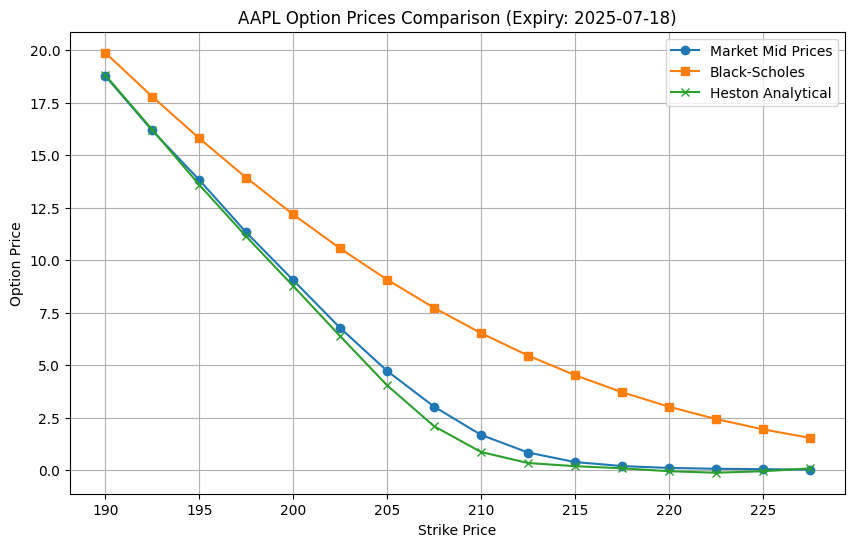

In [8]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

# --- Fetch Option Chain and Filter ATM Calls ---
ticker = "AAPL"
tkr = yf.Ticker(ticker)

# Automatically select nearest available expiry
expiry = tkr.options[0]  # Nearest expiry
print(f"Using expiry: {expiry}")

# Load option chain for selected expiry
option_chain = tkr.option_chain(expiry)
calls = option_chain.calls.copy()

# Current spot price
spot_price = tkr.history(period="1d")["Close"].iloc[-1]

# Filter ATM calls (within ±10% of spot price)
atm_range = 0.1
atm_calls = calls[(calls['strike'] >= spot_price * (1 - atm_range)) &
                  (calls['strike'] <= spot_price * (1 + atm_range))]

# Strike prices and market mid prices
strikes = atm_calls['strike'].values
market_mid_prices = ((atm_calls['bid'] + atm_calls['ask']) / 2).values

# --- Black-Scholes Model ---
def black_scholes_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# --- Option Pricer with Heston Analytical ---
class OptionPricer:
    def __init__(self, S, K, T, r, sigma, heston_params):
        self.S = S
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.heston_params = heston_params

    def price_heston_analytical(self):
        from scipy.integrate import quad

        kappa, theta, sigma, rho, v0 = self.heston_params

        def heston_char_func(phi, Pnum):
            u = 0.5 if Pnum == 1 else -0.5
            b = kappa - rho * sigma if Pnum == 1 else kappa
            a = kappa * theta

            d = np.sqrt((rho * sigma * 1j * phi - b) ** 2 - sigma ** 2 * (2 * u * 1j * phi - phi ** 2))
            g = (b - rho * sigma * 1j * phi + d) / (b - rho * sigma * 1j * phi - d)

            C = (self.r * 1j * phi * self.T) + (a / sigma ** 2) * ((b - rho * sigma * 1j * phi + d) * self.T -
                 2 * np.log((1 - g * np.exp(d * self.T)) / (1 - g)))
            D = ((b - rho * sigma * 1j * phi + d) / sigma ** 2) * ((1 - np.exp(d * self.T)) / (1 - g * np.exp(d * self.T)))

            return np.exp(C + D * v0 + 1j * phi * np.log(self.S))

        def integrand(phi, Pnum):
            numerator = np.exp(-1j * phi * np.log(self.K)) * heston_char_func(phi, Pnum)
            return np.real(numerator / (1j * phi))

        integral1 = quad(lambda phi: integrand(phi, 1), 0, 100)[0]
        integral2 = quad(lambda phi: integrand(phi, 2), 0, 100)[0]

        P1 = 0.5 + (1 / np.pi) * integral1
        P2 = 0.5 + (1 / np.pi) * integral2

        return self.S * P1 - self.K * np.exp(-self.r * self.T) * P2

# --- Model Parameters ---
r = 0.05  # Assumed risk-free rate
T = (pd.to_datetime(expiry) - pd.Timestamp.today()).days / 365  # Time to expiry
# sigma = 0.25  # Approx historical volatility


optimal_params = (0.5000000004380865, 0.0027922026202455616, 0.02488502340408709, -5.61660291615257e-27, 0.04)  # Example Heston params: (kappa, theta, sigma, rho, v0)


# --- Model Prices ---
bs_prices = [black_scholes_price(spot_price, K, T, r, sigma) for K in strikes]
heston_prices = []
for K in tqdm(strikes, desc="Heston Analytical Pricing"):
    pricer = OptionPricer(spot_price, K, T, r, sigma, optimal_params)
    heston_prices.append(pricer.price_heston_analytical())
heston_prices = np.array(heston_prices)

# --- Plot Market vs Model Prices ---
plt.figure(figsize=(10, 6))
plt.plot(strikes, market_mid_prices, 'o-', label='Market Mid Prices')
plt.plot(strikes, bs_prices, 's-', label='Black-Scholes')
plt.plot(strikes, heston_prices, 'x-', label='Heston Analytical')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title(f'{ticker} Option Prices Comparison (Expiry: {expiry})')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
from sklearn.metrics import mean_squared_error

# Compute MSE for both models
bs_mse = mean_squared_error(market_mid_prices, bs_prices)
heston_mse = mean_squared_error(market_mid_prices, heston_prices)

print(f"Black-Scholes MSE: {bs_mse:.6f}")
print(f"Heston Analytical MSE: {heston_mse:.6f}")


Black-Scholes MSE: 14.879255
Heston Analytical MSE: 0.168813
